# Graph Neural Network prediction of soft matter system properties: a computational essay

Rowan Orlijan-Rhyne<sup>1</sup>
PHYS 094
May 2025

Mentors and collaborators: Amy Graves<sup>1</sup>, Siddhant Ranka<sup>1</sup>, Dane Morgan<sup>2</sup>, Ajay Annamareddy<sup>2</sup>, Katharina Vollmayr-Lee<sup>3</sup>

<sup>1</sup> Swarthmore College
<sup>2</sup> University of Wisconson
<sup>3</sup> Bucknell University

## Introduction

Hello!

*Given the interactive nature of a computational essay, this report adopts a somewhat informal tone.*

I hope you enjoy reading and following along with this journey!

Please reach out to me at [this personal email address](mailto:rowan.orlijanrhyne@gmail.com) with any questions or comments, given that this [Swarthmore](mailto:rorlija1@swarthmore.edu) one will soon be deprecated.


If you have not already done so, please familiarize yourself with the file structure of this essay and the guidelines for running the code! All of this information is found in the [README](./README.rtf).

In [121]:
# Import the dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ML Intro
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import time

# GNN
import torch
import random
import os
import shutil
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
import torch.optim as optim
from random import shuffle
from torch_scatter import scatter_add
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, ReduceLROnPlateau

# visualization
import networkx as nx
from torch_geometric.utils import to_networkx
import re
import cv2
from IPython.display import Video

### Have some fun learning about ML

Machine learning (ML) is a field of artificial intelligence focused on producing models that can learn from data, identify patterns, and make decisions with minimal human supervision. Rather than being explicitly programmed to perform a task, a machine learning model improves its performance by training on data.

The following is an example meant to introduce you to the general methodology and terms involved in ML:

In [125]:
def generate_data(n, noise_std, function_type="sine"):
    # function to generate example data
    np.random.seed(1)
    Z = np.random.normal(0, noise_std, n)

    if function_type == "sine":
        X = np.linspace(-10 * np.pi, 10 * np.pi, n)
        Y = X * np.sin(X) + Z
        Y_denoised = X * np.sin(X)
    elif function_type == "cubic":
        X = np.linspace(-1, 1, n)
        Y = 3*(X**3) - 2*(X**2) + 8*X + Z
        Y_denoised = 3*(X**3) - 2*(X**2) + 8*X
    elif function_type == "linear":
        X = np.linspace(-5, 5, n)
        Y = 4*X + 2 + Z
        Y_denoised = 4*X + 2
    else:
        raise ValueError("Unsupported function type.")
    
    return X, Y, Y_denoised

def plot_data(n, noise_std, function_type):
    # function to plot data
    X, Y, Y_denoised = generate_data(n, noise_std, function_type)
    plt.figure(figsize=(10, 5))
    plt.scatter(X, Y, label="Noisy data", alpha=0.6, color="red")
    plt.plot(X, Y_denoised, label="Underlying function", color='black')
    plt.title(f"{function_type.capitalize()} function with n={n}, noise std={noise_std}")
    plt.xlabel("X (Feature)")
    plt.ylabel("Y (Target)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return X, Y, Y_denoised

Choose function type (linear, cubic, sine):  sine


We refer to the input variable(s) as our feature vector X,
And our output we'd like to learn to predict is called the target Y.
Giving more data to the model might make it easier for it to learn the task:


Enter number of samples (e.g. 200):  1000


And making the data noisier will introduce some difficulty:


Enter noise standard deviation (e.g. 5):  5


Can an ML model learn to master this regression task?
Generating plot...


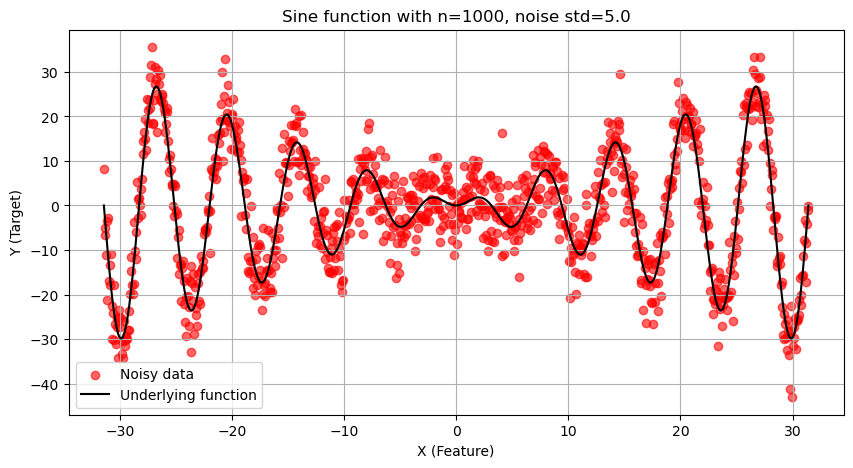

In [126]:
function_type = input("Choose function type (linear, cubic, sine): ").strip().lower()
print("We refer to the input variable(s) as our feature vector X,")
time.sleep(1)
print("And our output we'd like to learn to predict is called the target Y.")
time.sleep(1)
print("Giving more data to the model might make it easier for it to learn the task:")
time.sleep(1)
n = int(input("Enter number of samples (e.g. 200): "))
time.sleep(1)
print("And making the data noisier will introduce some difficulty:")
time.sleep(1)
noise_std = float(input("Enter noise standard deviation (e.g. 5): "))
time.sleep(1)
print("Can an ML model learn to master this regression task?")
print("Generating plot...")
time.sleep(1)
X, Y, Y_denoised = plot_data(n, noise_std, function_type)

In ML, we want to train the model on one portion of the available data and test it on another to avoid feeding it a task it has 'memorized' in a manner of speaking. We can also make the testing data more challenging by taking it from a range of the features unseen by the model.

Here, we'll use a portion of the above data for training and another for *validation* (evaluating the predivctive power of the model).

In [128]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

There are a variety of different machine learning *architectures* which you may have heard of or used before: linear regressor, singular value decomposition (SVD), decision trees, random forest, neural networks, convolutional neural networks, graph neural networks, variational autoencoders (VAEs), ... the list goes on.

The particular architecture chosen depends on the task you'd like to accomplish.

Let's see what various different model architectures can do for our basic ML task!

In [178]:
print("Available models: ")
print("     - linear regressor: 'linear'")
time.sleep(1)
print("     - random forest: 'forest'")
print("[A random forest is an ensemble of binary decision trees that vote on predictions,")
print("often averaging many independently trained trees to ensure convergence.]")
time.sleep(1)
print("     - neural network: 'mlp'")
print("[A neural network (here a multi-layer perceptron, MLP) consists of layers of interconnected nodes")
print("that apply linear and nonlinear transformations to inputs, enabling it to learn complex patterns.]")
time.sleep(2)
model_choice = input("Enter model type: ").strip().lower()

if model_choice == "linear":
    title = "Linear Regressor"
    model = LinearRegression()
elif model_choice == "forest":
    title = "Random Forest"
    model = RandomForestRegressor(n_estimators=100, random_state=6)
elif model_choice == "mlp":
    title = "Neural Network"
    model = MLPRegressor(hidden_layer_sizes=(256,), max_iter=1500, random_state=6)
else:
    raise ValueError("Unsupported model type.")

model.fit(X_train, Y_train)
print(f"Training {model_choice} model...")

Available models: 
     - linear regressor: 'linear'
     - random forest: 'forest'
[A random forest is an ensemble of binary decision trees that vote on predictions,
often averaging many independently trained trees to ensure convergence.]
     - neural network: 'mlp'
[A neural network (here a multi-layer perceptron, MLP) consists of layers of interconnected nodes
that apply linear and nonlinear transformations to inputs, enabling it to learn complex patterns.]


Enter model type:  forest


Training forest model...


Now that we have trained our chosen model, we can ask it to predict the behavior of our function Y(X) (plus noise). Let's see how it does, using a common metric, root mean squared error (RMSE).

In this context we refer to RMSE as our *loss function* because it quantifies the discrepancy between the model's predictions and the targets. Of course, the goal for a machine learning task is to minimize the loss function on the validation set. The model trains itself by minimizing the loss function on the training set, however, using an iterative process of updating its parameters.

In [180]:
Y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print(f"RMSE on validation data: {rmse:.2f}")

RMSE on validation data: 5.81


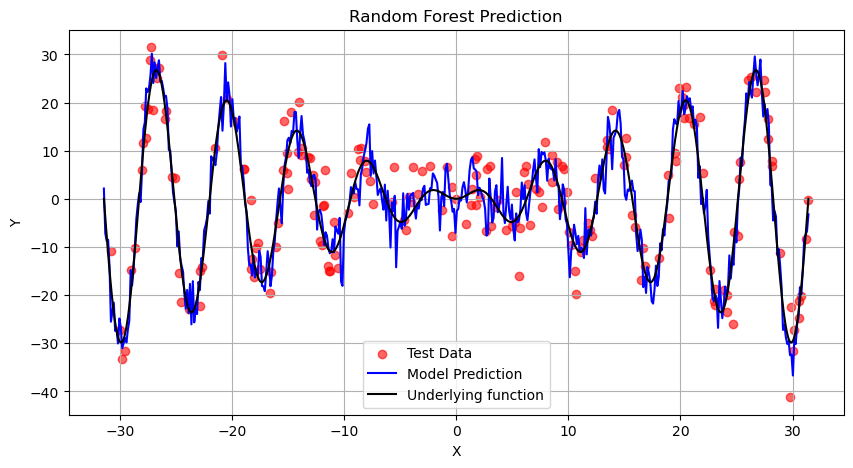

In [181]:
X_full = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
Y_full_pred = model.predict(X_full)

plt.figure(figsize=(10, 5))
plt.scatter(X_test, Y_test, label="Test Data", color='red', alpha=0.6)
plt.plot(X_full, Y_full_pred, label="Model Prediction", color='blue')
plt.title(f"{title.replace('_', ' ').title()} Prediction")
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(X, Y_denoised, label="Underlying function", color='black')
plt.legend()
plt.grid(True)
plt.show()

If you play around with different models and underlying functions, you might notice certain model architectures are better suited to different tasks.

You may also see that the RMSE has a lower bound determined by the standard deviation of the noise which you select: more noise means a higher RMSE, even if your model "knows" the underlying function quite well.

### Jamming and soft matter

Now let's turn to the physical systems and the data we'd like to study: 2-dimensional simulations of sheared bidisperse systems.

That probably sounds like gibberish, so we'll break it down:

Soft matter can be in solid, liquid, or gas phases, and we work with jammed systems of grains which are in the solid phase. Here, when we say "solid," we mean *disordered solid* (think beach sand). These systems are rigid and elastic, and the particles or grains of which they are comprised are densely packed. The phase transition from unjammed to jammed occurs at a critical density of particles described by the packing fraction

$\phi = n v_{1}$ where $n$ is the number density and $v_{1}$ is the volume of a single particle,

so that the packing fraction is the space occupied by particles as a fraction of the total space. In 2 dimensions, the critical packing fraction $\phi_{c} = 0.84$ at zero stress and temperature.

We can also apply a force to these systems which we refer to as a shear stress:

$\sigma = \frac{F}{A}$

In response to this shear stress, the system experiences a relative displacement, the strain:

$\epsilon = \frac{\Delta x}{L_{y}}$ where $L_{y}$ is the vertical dimension of the system.

For jammed grains the two are related with $G$, the shear modulus:

$\sigma = G \epsilon$

### LAMMPS: Large-scale atomic/molecular massively parallel simulator

LAMMPS is a piece of software developed by Sandia National Lab which we use to simulate 2-dimensional hard spheres in a microcanonical or NVE (i.e., fixed energy, fixed number of particles) ensemble. The simulation is athermal and isochoric.

The software iteratively tracks the evolution of a system of hard spheres using Newton's second law and subject to a harmonic potential. Particles of type A are defined to have a radius of $1$ unit, while type B particles have a radius of $1.4$ units, and their numbers are identically $N_{A} = N_{B} = 2048$. Their positions are uniformly assigned at random after which the system is "quenched" or undergoes a process of "healing." In this phase, the simulation is run with no shearing for a short time in order to allow the system to settle into a minimum energy configuration.

For our simulation, then, the packing fraction is

$\phi = (n_{A} \pi R_{A}^{2} + n_{B} \pi R_{B}^{2}) / L^{2}$

Below is an illustration of the minimization period of the simulation, courtesy of Akm S. Mahmud (Bucknell University).

![Minimization figure courtesy of Akm S. Mahmud (Bucknell University)](./images/minimization.png)

The system is then sheared, meaning the top and bottom walls move at a constant velocity and are unaffected by the forces of their contacts. The walls move at a shear rate of $\dot{\gamma} = 7.5 * 10^{-5}$, and this speed is slow enough so that the process is quasistatic. After the system is "healed," particles within three big particle diameters of the edges of the box are assigned to be wall particles.

Below is an illustration of the bidisperse sheared system. Pins (small fixed particles with radius 0.004) are pictured in bright green, but this report will not study systems with pins. Instead, see work from Amy Graves on predicting the distance of a particle from the nearest pin with graph neural networks. Wall particles are colored yellow, while system particles are blue and red. The wall speed $v$ is calculated using the shear rate $\dot{\gamma}$ as shown.

For further information about LAMMPS and its uses please see [Vollmayr-Lee 2020](https://www.eg.bucknell.edu/~kvollmay/AJP88_401_2020.pdf).

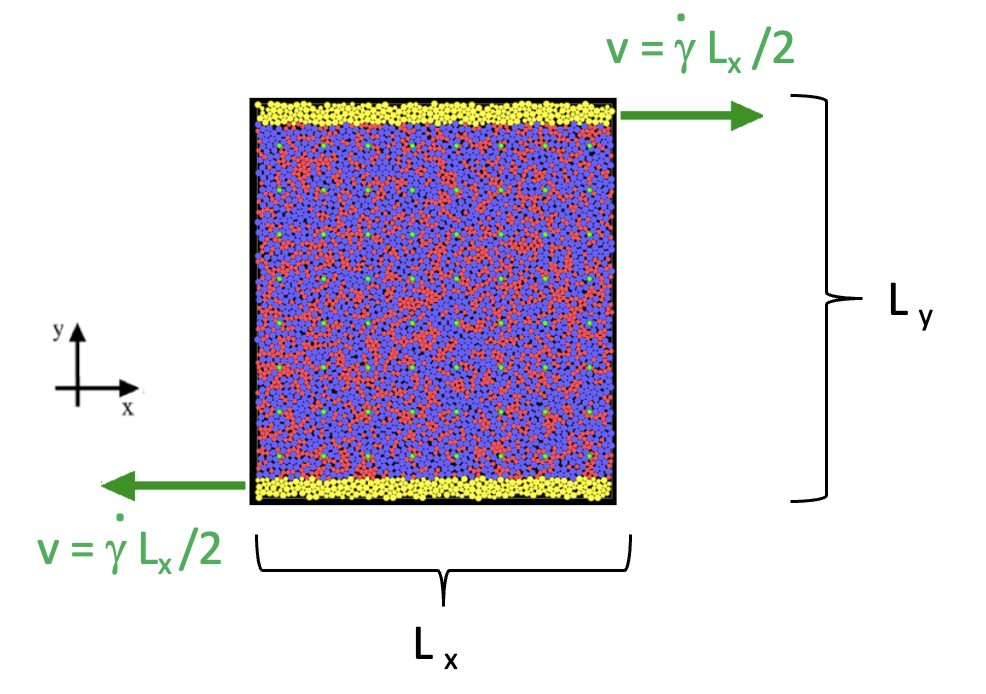

### ML and soft matter systems: a nod to the literature

[Cubuk et al. (2015)](https://doi.org/10.1103/PhysRevLett.114.108001)
- Support Vector Machines (SVMs) used on jammed and glassy solids to predict particle rearrangements and identify flow defects  
- Trained SVMs on local structural descriptors to identify "soft spots" or regions more prone to rearrangement. These soft spots were more predictive than traditional measures, providing insight into plastic deformation in amorphous solids.

---

[Baity-Jesi et al. (2018)](https://doi.org/10.48550/arXiv.1803.06969)
- Identified parallels between glassy physics and neural network optimization for deep neural networks (DNNs). Over-parameterized networks show slow relaxation akin to aging in glasses, while under-parameterized networks are more prone to being trapped in local minima.

---

[Bapst et al. (2020)](https://doi.org/10.1038/s41567-020-0842-8) ([Supplementary Info](https://static-content.springer.com/esm/art%3A10.1038%2Fs41567-020-0842-8/MediaObjects/41567_2020_842_MOESM1_ESM.pdf))
- Graph Neural Networks (GNNs) used on glass-forming systems to predict long-time dynamics from initial structure.
- GNNs accurately predicted dynamical heterogeneities and future rearrangements from static particle configurations, outperforming traditional methods and highlighting structure-dynamics correlations in glasses.

---

[Wang & Zhang (2021)](https://doi.org/10.1038/s41467-021-25490-x)
- Graph Neural Networks (GNNs) and Swap Monte Carlo used to predict the plastic resistance and structural stability of Cu-Zr metallic glasses.
- Found system states that are geometrically ultra-stable yet energetically metastable, drawing a distinction between mechanical robustness and energy minimization.

---

[Mandal & Sollich (2022)](https://doi.org/10.1038/s41467-022-31732-3) ([Supplementary Info](https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-022-31732-3/MediaObjects/41467_2022_31732_MOESM1_ESM.pdf))
- Graph Neural Networks (GNNs) used to predict force network structure in jammed solids under various system characteristics. 
- The authors find success for various parameters and show that the model can perform well on systems which differ from its training data. 

---

[Ridout & Liu (2024)](https://arxiv.org/abs/2406.05868)
- Used support vector machine (SVM) to learn softness parameter.
- Developed a model where particle rearrangement probability is governed by a learned "softness" metric. The model studies facilitation, or when single particle rearrangements affect the susceptibility of other particles to undergo displacements.

### GNNs: What are they, and why did we choose one?

You'll notice upon glancing at the "nod to the literature" above that some studies use support vector machines (SVMs) to study softness. More specifically, SVMs draw a hyperplane in the feature space to classify particles as being more or less susceptible to displacements, or with a higher/lower $D^{2}_{min}$ value. Other studies, however, use graph neural networks (GNNs) to study properties of jammed systems. This [gloss](https://deepmind.google/discover/blog/towards-understanding-glasses-with-graph-neural-networks/) of [Bapst et al. (2020)](https://doi.org/10.1038/s41567-020-0842-8) provides a good introduction to the subtleties and the advantages of using a GNN to study soft matter systems. This [paper](https://distill.pub/2021/gnn-intro/) provides insight into the architecture of GNNs.

In essence, we leverage Pytorch to create a graph representation of particles from a soft matter snapshot (or more than one), and the model performs transformations of the graph so that it can predict a per-particle property of our choosing. The creation of the graph designates each particle a 'node' with position information, and 'edges' are drawn between particles within a certain distance of each other so that the model can reliably capture their interactions. As you may know or soon learn, GNNs involve many different parameters/hyperparameters and can be modified with a variety of bells and whistles.

The weights and biases which govern the graph's transformations are updated via a process of 'training' in which a chosen loss function (e.g. RMSE, Huber Loss, binary cross entropy) describes the model's performance over time. As the weights and biases are optimized, the model explores the peaks and (ideally) valleys of the loss as a function of the model parameters. The way in which the model searches for minimum(s) of the loss function is governed largely by (i) the optimizer (determines the update vector of the weights, often computed using the gradient of the loss) and (ii) the learning rate (determines the amount by which the weights are displaced by the update vector).

To dive deeper into the way in which the weights are updated, we talk about a process called backpropagation, a method for computing gradients of a loss function with respect to the network's parameters.

In a GNN, each node starts with an initial feature vector which is then updated layer by layer through message passing, where each node aggregates information from its neighbors and combines it with its own features. This process propagates information across the graph, allowing each node to build a representation that reflects its local structure and context.

Each layer applies a linear transformation to the aggregated features, followed by a non-linear function called an activation function. We use the Rectified Linear Unit (ReLU) function, defined as:

$ \mathrm{ReLU}(x) = \max(0, x) $

The activation function introduces non-linearity into the model, allowing it to learn more complex patterns that a purely linear model could not capture. Once the final node representations are computed (after several layers), the model makes predictions and computes the loss. Backpropagation then computes how the model’s weights contributed to the loss, and the optimizer uses these gradients to update the weights in a direction that reduces the loss. This cycle of message passing, transformation, activation, loss computation, and weight update continues throughout training.

## Nearest Neighbors: a 'toy' problem

Rather than turn immediately to a task which might pose some challenges to the GNN, it is common in machine learning research to start with a problem that is very simple and predictable. This way, we can ensure we have a data processing methodology, a funcitonal model, and a good file structure and workflow.

LAMMPS provides us with what we term 'dump files' which write a range of data fields for each particle at a given molecular dynamics (MD) time step. LAMMPS also provides a separate file for each simulation run which enumerates the wall particles for ease of identification. We then pre-process these files to create a 'snapshot' file. This snapshot packages the relevant feature and target information for the Pytorch model to pick up and use as a graph, and the training and validation of the model is performed with a Python script.

We chose to predict the number of particles within a certain distance of each particle for our 'toy' problem.

### Pre-processing of LAMMPS data files

Here is what a typical LAMMPS file looks like:

In [206]:
md_data = np.genfromtxt('./MD_Data/confdumpallelasticMD0.data', delimiter='\t', dtype=str, encoding='utf-8')

for line in md_data[:12]:
    print(line)

ITEM: TIMESTEP
0
ITEM: NUMBER OF ATOMS
4556
ITEM: BOX BOUNDS pp ff pp
0.0000000000000000e+00 1.5011186343322501e+02
0.0000000000000000e+00 1.6691186343322499e+02
-1.0000000000000000e-02 1.0000000000000000e-02
ITEM: ATOMS id type x y vx vy fx fy xu yu c_shearStr[4] c_shearStr[1] c_shearStr[2] v_coordA v_coordB v_coordA_wall v_coordB_wall
1 1     3.8648859854e+01     3.2112242274e+00    -7.5055931717e-05     0.0000000000e+00     3.4586453725e-11     5.7813394608e-11     3.8648859854e+01     3.2112242274e+00     1.3519282798e-05    -1.2264112750e-05    -2.5524784962e-05 0 0 0 0
2 1     3.7909600531e+01     1.3528864139e+00    -7.5055931717e-05     0.0000000000e+00     2.6097361752e-05    -4.9940246666e-05     3.7909600531e+01     1.3528864139e+00    -5.7883085646e-06    -5.3316321409e-04    -1.3450328920e-04 0 0 0 0
3 1     1.6100689340e+01     4.3742392364e+00    -7.5055931717e-05     0.0000000000e+00     2.1923683691e-10     1.3667568596e-11     1.6100689340e+01     4.3742392364e+00    

The pre-processor reads the LAMMPS file, loops over all particles to find the number of neighbors within a certain cut-off distance, and uses this information as the target for the GNN. It also assigns a training flag (1) or validation flag (0) to particles. Here, I'll simply import our function from the pre-processor script and use it to generate the $\texttt{Snapshot\_1.graphdata}$ file for the GNN.

In [208]:
from pre_processors.Pre_processing_neighbors import process_lammps_dump
from customDataset import CustDataset

In [209]:
process_lammps_dump("MD_Data/confdumpallelasticMD0.data", "MD_Data/wallpartidtype", cutoff_distance=5.0, train_fraction=0.9)

Output written to Snapshot_1.graphdata


The $\texttt{customDataset.py}$ file reads data from the Snapshot_1 file in order to construct a graph representation of the data which is usable by Pytorch. The most important function of the script is the $\texttt{getitem(self, index)}$ method which governs the initialization of nodes and edges, and I will give some code/pseudocode snippets of this method below rather than simply calling the $\texttt{CustDataset}$ class which we have imported above.

In [211]:
img_path = './Snapshot_1.graphdata'
x = np.loadtxt(img_path)
temp = np.array(x)
box = temp[0,:2] # simulation box length in x and y dimensions
positions = temp[1:,1:3] # atom x,y-coordinates
wall_flag = temp[1:,3] # is particle a wall particle?
target = temp[1:,4] # what is the target property for this particle?

# define the edge threshold h, which determines whether or not particles/nodes will be connected by an edge in the graph
h = 5.0 # edge threshold

In [212]:
# identifying nodes that are part of training and validation data
train_mask = (temp[1:,5]==1)
val_mask = (temp[1:,5]==0)
print(train_mask.sum(),val_mask.sum())

# Atom type encoding (one-hot) -- convert to something Pytorch can handle
atom_type = torch.tensor(temp[1:,0] - 1) # atom type (assuming 0-based indexing)
atom_type = torch.nn.functional.one_hot(atom_type.to(torch.int64), num_classes=-1) #0->[1,0]; 1->[0,1]
atom_type = atom_type.clone().detach().to(torch.float)

# is particle a wall particle?
# Wall flag encoding (binary feature)
wall_flag = torch.tensor(wall_flag).unsqueeze(1).float()  # (n_nodes, 1)

# Concatenate atom type and wall flag to create final node features
node_features = torch.cat([atom_type, wall_flag], dim=1)  # Concatenate along the feature dimension

# Calculate pairwise relative distances between particles: shape [n, n, 2].
cross_positions = positions[np.newaxis, :, :] - positions[:, np.newaxis, :]
# Enforce periodic boundary conditions in the x-direction only
box_x = box[0]
cross_positions[:, :, 0] += (cross_positions[:, :, 0] < -box_x / 2.) * box_x
cross_positions[:, :, 0] -= (cross_positions[:, :, 0] > box_x / 2.) * box_x


distances = np.linalg.norm(cross_positions, axis=-1)
indices = np.where(distances < h)

mask = indices[0] != indices[1]
senders = list(indices[0][mask]); receivers = list(indices[1][mask])
edge_index = torch.tensor([senders,receivers],dtype=torch.long)

edges = cross_positions[senders[0],receivers[0]]

for i,j in zip(senders[1:],receivers[1:]):
    edges = np.vstack([edges, cross_positions[i,j]])
 
edge_attr = torch.tensor(edges, dtype=torch.float)

globals = torch.zeros((1,1),dtype=torch.float)
    
positions = torch.tensor(positions, dtype=torch.float)

4100 456


In [213]:
# now we have our target:
y = torch.tensor(target, dtype=torch.float)
# and our graph representation of the system:
data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, globals=globals, train_mask=train_mask, val_mask=val_mask)

In [214]:
# To visualize the graph structure
mask = temp[1:,0]
mask = torch.tensor(mask, dtype=torch.int)
mask = mask.bool()
color = mask
data = Data(color=color,x=node_features, edge_index=edge_index, edge_attr=edge_attr, globals=globals, train_mask=train_mask, val_mask=val_mask)

In [215]:
def visualize_graph(data, color='skyblue'):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=False,
        node_color=color,
        node_size=10,
        alpha=0.4,
        edge_color='gray',
        width=0.2
    )
    plt.show()

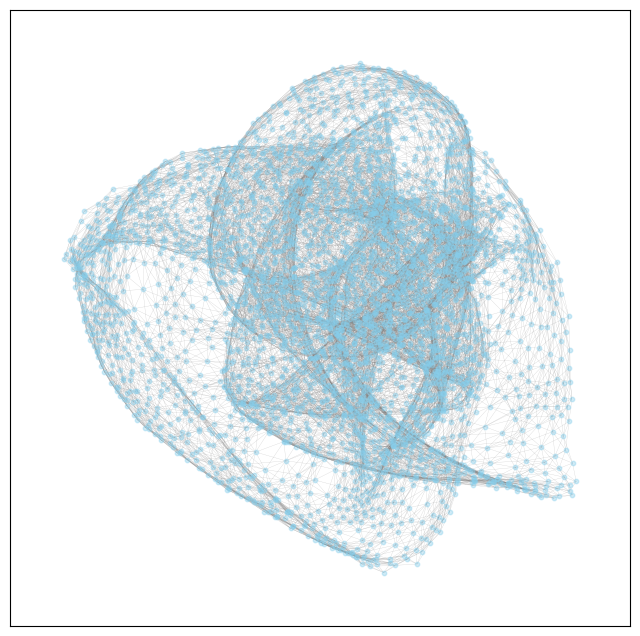

In [216]:
visualize_graph(data, 'skyblue')

This looks cool, but it doesn't tell us (or at least me) much about the physics of the system... and that's the point!

In other words, we've moved from our MD system snapshot to a graph which will be fed to the GNN.

### GNN implementation

#### Pytorch architecture

Drawing from the $\texttt{gnn\_old.py}$ script, which constitutes the skeleton of the GNN which we have since built upon and refined, I will give you an idea of the mechanism of a PyTorch GNN implementation. The $\texttt{gnn\_with\_train\_and\_savedmodel.py}$ version is also provided, which expands upon the original model by writing actual and predicted values for training and validation and by allowing the training loop to be stopped and picked up again from a given checkpoint.

For all versions of the GNN code, see this [Google Drive folder](https://drive.google.com/drive/folders/1qoVhFsLf4IrfTRDPD7tuH26-kurvxgfZ?usp=sharing). The most advanced, discussed below, is $\texttt{gnn\_ema\_earlystop\_norm.py}$.

The model follows the structure of an interaction network, which is a type of message-passing neural network designed for learning on graphs. It uses separate models for updating edge features, node features, and (optionally) global graph-level features.

The $\texttt{EdgeModel}$ class defines how the attributes of graph edges are updated. For each edge, it considers:

- The features of the source and destination nodes it connects
- Its own edge attributes

These are concatenated and passed through a multi-layer perceptron (MLP) with ReLU activations:

In [222]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super(EdgeModel, self).__init__()
        self.edge_mlp = nn.Sequential(nn.Linear(2*(2*emb_dim+emb_dim), emb_dim), # 2*num_node_features + num_edge_features
                            nn.ReLU(),
                            nn.Linear(emb_dim, emb_dim),
                            nn.ReLU())

    def forward(self, src, dest, edge_attr, u, batch):
        out = torch.cat([src, dest, edge_attr], 1) # out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        out = self.edge_mlp(out)
        return out

The $\texttt{NodeModel}$ class defines how node attributes are updated. The process is as follows:

1) Each node receives messages from its neighbors via incoming edges, where messages are computed using the sender node's features and edge attributes.
2) These messages are summed up and concatenated with the node's own features.
3) The resulting vector is passed through another MLP to produce updated node features.

In [224]:
class NodeModel(torch.nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.node_mlp_1 = nn.Sequential(nn.Linear(2*emb_dim+emb_dim, emb_dim),
                              nn.ReLU(), 
                              nn.Linear(emb_dim, emb_dim),
                              nn.ReLU())
        self.node_mlp_2 = nn.Sequential(nn.Linear(2*emb_dim+emb_dim, emb_dim),
                              nn.ReLU(), 
                              nn.Linear(emb_dim, emb_dim),
                              nn.ReLU())

    def forward(self, x, edge_index, edge_attr, u, batch):
        senders, receivers = edge_index
        out = torch.cat([x[senders], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_add(out, receivers, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1) # out = torch.cat([x, out, u[batch]], dim=1)
        out = self.node_mlp_2(out)  
        return out

The $\texttt{GlobalModel}$ is intended to update global (graph-level) attributes. In this implementation, it is set to an identity mapping, meaning no global features are used or updated.

In [226]:
class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        """self.global_mlp = nn.Sequential(nn.Linear(emb_dim+1, emb_dim), #num_node_features + num_edge_features + 1
                              nn.BatchNorm1d(emb_dim),
                              nn.ReLU(), 
                              nn.Linear(emb_dim, emb_dim))"""
        self.global_mlp = nn.Identity()

    def forward(self, x, edge_index, edge_attr, u, batch):
        # out = torch.cat([u, scatter_add(x, batch, dim=0)], dim=1)
        # return self.global_mlp(out)
        return self.global_mlp(u)

The full $\texttt{InteractionNetwork}$ class orchestrates the entire GNN as follows:

1) Encoding: Node and edge features are first projected into a higher-dimensional embedding space using separate MLP encoders.
2) Message Passing: The GNN runs for a user-defined number of layers of message passing. In each layer: (i) Edges are updated based on node features and previous edge features. (ii) Nodes are then updated based on messages from edges. (iii) Previous embeddings are concatenated to stabilize learning.
5) Output: Final node features are passed through fully connected layers to produce per-node predictions.

In [228]:
class InteractionNetwork(torch.nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()

        MLP_dim = 256 #num. of neurons in fully-connected layers at the end
        
        self.fc1 = nn.Linear(node_dim, emb_dim)
        self.fc2 = nn.Linear(emb_dim, emb_dim)
        
        self.fc3 = nn.Linear(emb_dim, MLP_dim)
        self.fc4 = nn.Linear(MLP_dim, MLP_dim)
        self.fc5 = nn.Linear(MLP_dim, output_dim)

        self.edgefc1 = nn.Linear(edge_dim, emb_dim)
        self.edgefc2 = nn.Linear(emb_dim, emb_dim)

        self.act = nn.ReLU()

        self.interactionnetwork = MetaLayer(edge_model=EdgeModel(), node_model=NodeModel(), global_model=None)
        # self.bn = BatchNorm1d(inputs)
        
    def forward(self, data):
        
        MP_layers = 7 # num. of message-passing layers
        x, edge_index, edge_attr, globals, batch = data.x, data.edge_index, data.edge_attr, data.globals, data.batch #x = self.bn(x)

        #encoder phase
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        
        edge_attr = self.edgefc1(edge_attr)
        edge_attr = self.act(edge_attr)
        edge_attr = self.edgefc2(edge_attr)
        edge_attr = self.act(edge_attr)
        
        save_x = x
        save_edge_attr = edge_attr
        
        #Message-passing layers
        for _ in range(MP_layers):
          #concatenate current values with 'save'd values.. concept of residual network
          x = torch.cat([x, save_x], dim=1)
          edge_attr = torch.cat([edge_attr, save_edge_attr], dim=1)
          
          x, edge_attr, globals = self.interactionnetwork(x=x, edge_index=edge_index, edge_attr=edge_attr, u=None, batch=batch)

        x = self.fc3(x)
        x = self.act(x)
        x = self.fc4(x)
        x = self.act(x)
        x = self.fc5(x)
        
        return x

In the context of our application of the GNN architecture to LAMMPS dump files, the number of message passing layers is a reflection of how far information can propagate through the system. This characteristic of the GNN combined with the edge threshold parameter in our data pre-processor determine the model's capacity to predict targets which are correlated with the graph structure. In other words, to predict distance information from each particle to a landmark (say, a pin, which Amy Graves has demonstrated in Siddhant Ranka's report), the model is very capable of predicting distances up until a distance of $N_{MP\_layers} * edge\_threshold$, after which point it can still learn the target but with less ease.

In [230]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The following parameters govern the processing of the graph data by the GNN:

In [232]:
# Parameters and Hyperparameters
node_dim = 3 # node feature dimension: x and y coordinates (2) and whether particle is wall particle (3)
edge_dim = 2 # 2D relative position vector between nodes
output_dim = 1 # single-dim target (number of neighbors)
edge_threshold = 5.0 # two nodes form an edge if separation shorter than threshold
emb_dim = 64 # embedding dimension of the nodes and edges

while, as described above, the learning rate determines the amount by which the weights are displaced by the update vector at each pass through the training data. A learning rate that is small might allow for a meticulous navigation of the loss function towards a favorable minimum, at the expense of a slow convergence or of updates to the weights that are so small they cause floating point error. On the other hand, a learning rate that is large might enable the model to jump from a local to a global minimum and to gather a holistic representation of the loss landscape, but this could also produce models which diverge or which oscillate capriciously rather than actually reaching the bottom of a valley in the loss.

Each pass through the training data constitutes an 'epoch.' So, in theory, running a convergent model for increasing numbers of epochs would result in better and better performance.

In [234]:
learning_rate = 0.0001
num_epochs = 1

In [235]:
dataset = CustDataset(h=edge_threshold, root_dir='./')
data_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
cache_directory = 'cached_data'

if os.path.exists(cache_directory): shutil.rmtree(cache_directory)
os.makedirs(cache_directory, exist_ok=True)

Move the data into the cache directory and onto the device, and initialize the model. To save a little time, I've included a saved model state in the $\texttt{savedmodel\_neighbors.pkl}$ file, which has been trained for 520 epochs to achieve an RMSE of below $10^{-5}$ (in units of neighbors per particle). So, we'll load this state and all of its learned parameters rather than starting from an untrained model.

In [237]:
for i, (data, targets) in enumerate(data_loader):
    torch.save((data,targets), os.path.join(cache_directory, f'data_{i}.pt'))

if os.path.exists("./saved_model_states/savedmodel_neighbors.pkl"):
    # resume training from previous model state
    print("Loading existing model...")
    model = torch.load("./saved_model_states/savedmodel_neighbors.pkl", weights_only=False)
else: # otherwise start new model
    print("Initializing new model...")
    model = InteractionNetwork()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")

model.to(device)

4100 456
Loading existing model...


InteractionNetwork(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=1, bias=True)
  (edgefc1): Linear(in_features=2, out_features=64, bias=True)
  (edgefc2): Linear(in_features=64, out_features=64, bias=True)
  (act): ReLU()
  (interactionnetwork): MetaLayer(
    edge_model=EdgeModel(
    (edge_mlp): Sequential(
      (0): Linear(in_features=384, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
    )
  ),
    node_model=NodeModel(
    (node_mlp_1): Sequential(
      (0): Linear(in_features=192, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
    )
    (node_mlp_2): Sequential(
      (0): Linear(in_

#### Loss function (RMSE)

The loss function we use is root mean squared error (RMSE), which is standard for regression tasks such as our own.

Below we plot the RMSE of our model across its first 500 epochs of training on a log-log scale:

![Log(RMSE) from saved model state across 500 epochs](./images/Neighbors_savedmodel_RMSE.png)

#### Training and evaluation

The loss function and optimizer are set here. We use $\texttt{Adam}$ (adaptive moment estimation), which updates weights by tracking the mean and variance of the loss function's gradient as weighted averages of the current and previous states.

However, I am also interested in testing simpler optimizers: stochastic gradient descent (SGD) simply uses the current loss gradient; and AdaGrad (adaptive gradient) normalizes the learning rate for each parameter by a factor proportional to the sum of the squares of previous loss gradients and thus can differentiate which parameters need to be updated by larger amounts.

In [243]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In the GNN versions we use, a $\texttt{check\_accuracy()}$ function is called at each epoch (i.e., iteration of the training loop) which computes RMSE and writes the actual/target and predicted/model-output values to a file). We also write the learning rate at each epoch and save the model state. For our purposes, instead of writing a file, we'll simply make a couple print statements:

In [245]:
def check_accuracy(cache_files, model, phase):
    model.eval()
    quantify = 0.0
    count = 0
    if phase == 'train': print_phase = 'training'
    if phase == 'val': print_phase = 'validation'

    with torch.no_grad():
        for cache_file in cache_files:
            data, targets = torch.load(os.path.join(cache_directory, cache_file), weights_only=False)
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            scores = scores.reshape(-1)
            targets = targets.reshape(-1)

            mask = np.array(data.train_mask if phase == "train" else data.val_mask).reshape(-1)
            masked_indices = np.where(mask)[0]

            quantify += criterion(scores[mask], targets[mask])
            count += 1

            # Randomly select 3 indices from the valid (masked) entries
            if len(masked_indices) >= 3:
                selected_indices = random.sample(list(masked_indices), 3)
            else:
                selected_indices = masked_indices

            print("Sampled predictions for number of neighbors of 3 random %s particles:" % print_phase)
            for idx in selected_indices:
                print(f"Actual: {targets[idx].item():.4f}, Predicted: {scores[idx].item():.4f}")

    print()
    print("RMSE is %s\n" % (quantify.item() / count))

    # we'll just return the actual and predicted values for use below
    actual_vals = targets[mask]
    predicted_vals = scores[mask]

    return actual_vals, predicted_vals


We'll now run one epoch of training of this model for the neighbors task. Normally, the code below is wrapped in a for loop and iterates for as many epochs as we'd like, but we'll avoid this for now. We also won't save the model's weights and biases after our single epoch to reduce clutter in the file structure of this computational essay :)

In [247]:
epoch = 521
for phase in ['train', 'val']:
    if phase == 'train':
      model.train()  # Set model to training mode
    else:
      model.eval()   # Set model to evaluate mode

    running_loss = 0.
    count = 0

    cache_files = [f for f in os.listdir(cache_directory) if f.endswith('.pt')]
    if phase == 'train': shuffle(cache_files)
    for cache_file in cache_files:
      data,targets = torch.load(os.path.join(cache_directory, cache_file),weights_only=False)
      data = data.to(device=device)
      targets = targets.to(device=device)

      if phase == 'train': mask = data.train_mask
      else: mask = data.val_mask

      # Determine the batch size for this graph
      if phase == 'train': batch_size = 32
      else: batch_size = np.sum(mask)
      true_indices = np.where(mask)[1]
      num_batches = (len(true_indices) + batch_size - 1) // batch_size

      # Iterate through nodes in batches
      for i in range(num_batches):
        optimizer.zero_grad()
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(true_indices))

        batch_indices = true_indices[start_idx:end_idx]
        node_batch = np.zeros(len(mask[0]), dtype=bool)
        node_batch[batch_indices] = True

        with torch.set_grad_enabled(phase == 'train'):
          optimizer.zero_grad()
          scores = model(data)
          scores = scores.reshape(-1); targets = targets.reshape(-1); node_batch = np.array(node_batch).reshape(-1)
          loss = criterion(scores[mask], targets[mask])
          running_loss +=loss.item()
          count += 1

          # backward + optimize (update weights) only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

    if phase == 'train': print_phase = 'Training'
    if phase == 'val': print_phase = 'Validation'

    print('{} Loss - epoch {}: {:.10f}'.format(print_phase, epoch, running_loss/count))

    if phase == 'train':
        actual_train, predicted_train = check_accuracy(cache_files, model, phase)
    if phase == 'val':
        actual_val, predicted_val = check_accuracy(cache_files, model, phase)
        
epoch += 1

Training Loss - epoch 521: 0.0146228623
Sampled predictions for number of neighbors of 3 random training particles:
Actual: 13.0000, Predicted: 13.0022
Actual: 13.0000, Predicted: 12.9996
Actual: 12.0000, Predicted: 12.0002

RMSE is 9.684817086963449e-06

Validation Loss - epoch 521: 0.0000098543
Sampled predictions for number of neighbors of 3 random validation particles:
Actual: 12.0000, Predicted: 11.9915
Actual: 14.0000, Predicted: 13.9981
Actual: 17.0000, Predicted: 17.0002

RMSE is 9.854327799985185e-06



You can keep re-running the above cell if you'd like, and you might see the loss continue to decrease as we iterate over the training data and train the model for more and more epochs.

Otherwise, that's it for our skeleton GNN!

Our sampled predictions for 3 random particles should show you that the model is quite successful in predicting the number of neighbors per particle within a certain distance, and we'll discuss another method of visualizing this below: the parity plot.

### Performance: the parity plot

The parity plot graphs the actual (target) values as a function of the model's predicted values.

The line $\texttt{y=x}$ indicates perfect model performance where predictions match the target. Vertical lines on the graph indicate 'false negatives' whereas horizontal lines indicate 'false positives.'

For the neighbors task, the actual values are discrete integer values.

Here is a parity plot of our current model's predictions, using the actual and predicted values we've just generated:

In [251]:
def parity_plot(y_train_actual, y_train_pred, y_val_actual, y_val_pred, title):
    plt.figure(figsize=(12, 6))

    # Training Parity Plot
    plt.subplot(1, 2, 1)
    plt.plot([y_train_actual.min(), y_train_actual.max()],
         [y_train_actual.min(), y_train_actual.max()],
         'k--', lw=1, label='Ideal', alpha=0.5)
    plt.scatter(y_train_actual.cpu(), y_train_pred.cpu(), 
                facecolors='none', edgecolors='blue', alpha=0.5, label='Training')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Training Parity Plot %s' % title)
    plt.legend()

    # Validation Parity Plot
    plt.subplot(1, 2, 2)
    plt.plot([y_val_actual.min(), y_val_actual.max()],
         [y_val_actual.min(), y_val_actual.max()],
         'k--', lw=1, label='Ideal', alpha=0.5)
    plt.scatter(y_val_actual.cpu(), y_val_pred.cpu(), 
                facecolors='none', edgecolors='green', alpha=0.5, label='Validation')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Validation Parity Plot %s' % title)
    plt.legend()

    plt.tight_layout()
    plt.show()

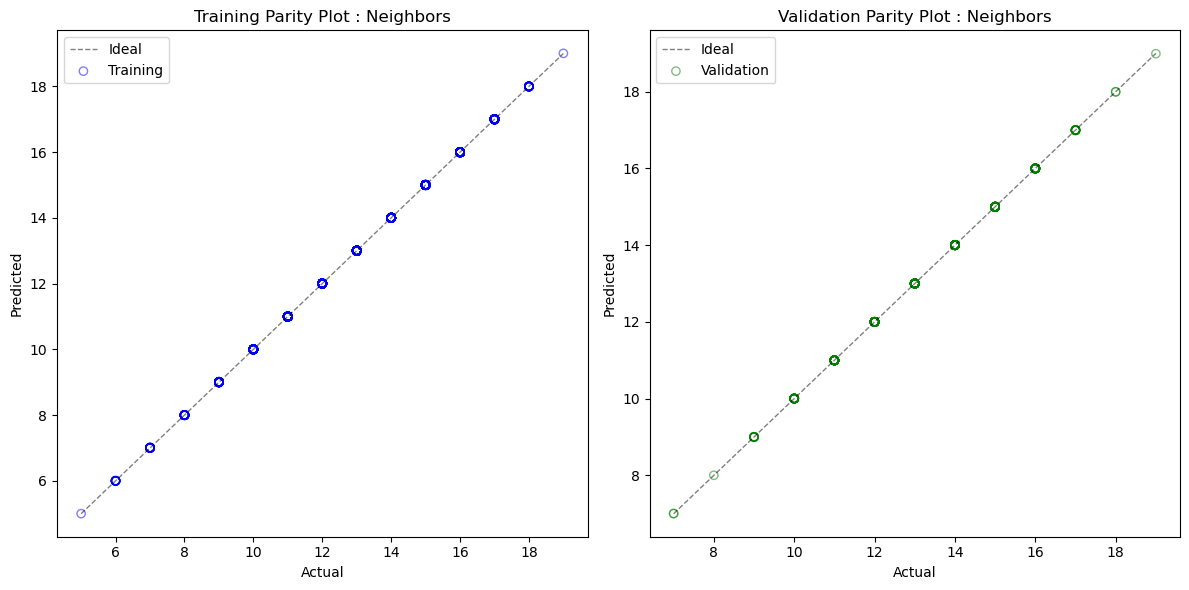

In [252]:
parity_plot(actual_train, predicted_train, actual_val, predicted_val, ": Neighbors")

### Hyperparameters, and how we choose them: tuning

In its current state, the main parameter which we'd like to optimize is the learning rate. The number of message passing layers, the embedded dimension, the edge threshold, and the multi-layer perceptron (MLP) dimension are also important to keep in mind.

Ideally, to find the best learning rate, we would train the model on a range of learning rates for hundreds of epochs and repeat this training process a few times to ensure the reproducibility and veracity of our conclusions. Since this was our 'toy' problem, however, we ran the model for 20 epochs for a variety of learning rates and found $10^{-4}$ to produce the lowest RMSE. 

## Predicting x-displacements at multiple MD timesteps

We now turn to a more interesting task: predicting x-displacements in the system based on position information for the particles at a prior time step.

Although it will be easier to train a model to predict displacements at short time steps, you can imagine the power of an algorithm to predict displacements at long time steps: In essence, if the model can extrapolate to different system conditions, it would replace a deterministic, computationally heavy software package like LAMMPS.

### Displacement in a system of sheared grains

The particles in the system begin at rest, and as the system is sheared, the 'information' of the shearing displacement percolates from the moving walls up and down through the system.

To predict the displacement of our system, we need to understand the target and its complexities. Let's first create some visualizations of our data to study its characteristics. For times at which the information has completely penetrated the system, we might expect the particles to displace in an affine manner. (Note: this is because there are no pins in the configurations which we are studying here. If we were to introduce pins, we'd see some non-affine displacements.)

The figure below from Amin Danesh (Bucknell) illustrates the nature of this affine displacement as a function of y-coordinate in the simmulation.

![Affine displacements courtesy of Amin](./images/affine_displacement.png)

We'll use the LAMMPS dump files in the $\texttt{MD\_Data}$ directory to create our visualizations.

First we define functions for file IO and data accumulation:

In [261]:
def get_filename_for_timestep(timestep, folder='.'):
    """
    Returns the filename in `folder` corresponding to the timestep.
    Looks for files matching pattern 'confdump*MD<timestep>.data'.
    """
    pattern = re.compile(r'confdump.*MD' + str(timestep) + r'\.data')
    for filename in os.listdir(folder):
        if pattern.match(filename):
            return os.path.join(folder, filename)
    raise FileNotFoundError(f"No file found for timestep {timestep}")

In [262]:
def read_simulation_metadata(filename):
    with open(filename, 'r') as f:
        lines = [next(f) for _ in range(8)]
    Nall = int(lines[3].split()[0])
    Lx = float(lines[5].split()[1])
    Ly = float(lines[6].split()[1])
    return Nall, Lx, Ly

def load_particle_data(filename):
    header = np.loadtxt(filename, skiprows=8, max_rows=1, dtype=str)
    header[4:6] = ['dx', 'dy']  # Rename columns
    data = np.loadtxt(filename, skiprows=9, usecols=range(17), unpack=True)
    return header, data

def read_wall_particles(filename):
    with open(filename, 'r') as f:
        lines = [next(f) for _ in range(8)]
    Nwall = int(lines[3].split()[0])
    data = np.loadtxt(filename, skiprows=9, usecols=(0, 1), unpack=True)
    return Nwall, data

def extract_wall_indices(idarrayall, idarraywall):
    """Returns boolean mask or indices for wall particles."""
    return np.isin(idarrayall, idarraywall)

def data_func(tMD, t_0, folder = './MD_Data'):
    """Processes simulation and wall data to extract displacement and other arrays."""
    file_wall = os.path.join(folder, "wallpartidtype")
    file_init = get_filename_for_timestep(t_0, folder)
    file_final = get_filename_for_timestep(tMD, folder)
    print(f"Loading data from final time: {file_final}")
    print(f"Loading data from init time: {file_init}")

    Nall, Lx, Ly = read_simulation_metadata(file_final)

    Nall_init, Lx_init, Ly_init = read_simulation_metadata(file_init)
    
    if Nall != Nall_init:
        raise Exception('MD system configuration at final time step does not match initial time step.')

    # Read wall data
    Nwall, wall_data = read_wall_particles(file_wall)
    idarraywall, typearraywall = wall_data
    Nmid = Nall - Nwall

    # Load particle data
    header, data_final = load_particle_data(file_final)
    _, data_init = load_particle_data(file_init)

    idarrayall = data_final[0]
    typearrayall = data_final[1]
    xarrayall, yarrayall = data_final[2], data_final[3]
    vxarrayall, vyarrayall = data_final[4], data_final[5]
    fxarrayall, fyarrayall = data_final[6], data_final[7]
    sigxyarrayall = data_final[8]
    # skip columns 9-16 if unused

    xarrayall_init, yarrayall_init = data_init[2], data_init[3]
    vxarrayall_init, vyarrayall_init = data_init[4], data_init[5]

    dxarrayall = xarrayall - xarrayall_init
    dyarrayall = yarrayall - yarrayall_init

    # Get wall indices
    wall_mask = extract_wall_indices(idarrayall, idarraywall)

    # Extract mid particles (inverse mask)
    mid_mask = ~wall_mask
    idarraymid = idarrayall[mid_mask].astype(int)
    typearraymid = typearrayall[mid_mask].astype(int)
    xarraymid = xarrayall[mid_mask]
    yarraymid = yarrayall[mid_mask]
    xarraymid_init = xarrayall_init[mid_mask]
    yarraymid_init = yarrayall_init[mid_mask]
    dxarraymid = xarraymid - xarraymid_init
    dyarraymid = yarraymid - yarraymid_init
    vxarraymid = vxarrayall[mid_mask]
    vyarraymid = vyarrayall[mid_mask]
    fxarraymid = fxarrayall[mid_mask]
    fyarraymid = fyarrayall[mid_mask]
    sigxyarraymid = sigxyarrayall[mid_mask]

    # Extract wall coordinates
    wall_indices = np.searchsorted(idarrayall, idarraywall)
    xarraywall = xarrayall[wall_indices]
    yarraywall = yarrayall[wall_indices]
    xarraywall_init = xarrayall_init[wall_indices]
    yarraywall_init = yarrayall_init[wall_indices]

    # Count mid region types
    Namid = np.sum(typearraymid == 1)
    Nbmid = np.sum(typearraymid == 2)
    Npinmid = np.sum(typearraymid == 3)

    return (header[2:8], idarrayall, typearrayall, dxarrayall, dyarrayall,
            vxarrayall, vyarrayall, xarraymid, yarraymid, xarraywall, yarraywall,
            dxarraymid, dyarraymid, typearraywall.astype(int), typearraymid.astype(int),
            Nmid, Nwall, Lx, Ly)

Now we can plot histograms as well as visualizations of the system at various time steps.

In [264]:
def plot_displacement_histograms(x_displacements, y_displacements, types, tMD, t_0):
    """Plots histograms for displacement data."""

    def _plot_and_save(x, y, net, label):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for ax, data, title, color in zip(
            axes,
            [x, y, net],
            ['X Displacement', 'Y Displacement', 'Net Displacement'],
            ['blue', 'green', 'red']
        ):
            counts, bins, patches = ax.hist(data, bins=50, color=color, alpha=0.7, edgecolor='black')
            patch_heights = counts / counts.sum()
            for patch, height in zip(patches, patch_heights):
                patch.set_height(height)
            ax.set_title(title)
            ax.set_xlabel("Displacement")
            ax.set_ylabel("Fraction of Total")
            ax.set_ylim(0, 1)
        fig.suptitle(f"Displacements at {tMD} timesteps from {t_0}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"./images/displacement_plots/plots/disp_hist_{label}_{tMD}.png")
        plt.close()

    net_displacements = np.hypot(x_displacements, y_displacements)

    _plot_and_save(x_displacements, y_displacements, net_displacements, 'ALL')
    for ttype, label in [(1.0, 'A'), (2.0, 'B')]:
        mask = types == ttype
        _plot_and_save(x_displacements[mask], y_displacements[mask], net_displacements[mask], label)

def displacement_heatmap(xmid, ymid, xwall, ywall, dxmid, dymid, typewall, typemid, t, t_0, Nmid, Nwall, Lx, Ly):
    """Plots displacement heatmaps."""
    Ra, Rb, Rpindraw = 1.0, 1.4, 0.4
    net_disp = np.hypot(dxmid, dymid)
    displacements = {'NET': net_disp, 'X': np.abs(dxmid), 'Y': np.abs(dymid)}

    for label, disp in displacements.items():
        disp_norm = (disp - disp.min()) / (disp.ptp() if disp.ptp() > 0 else 1)
        colormaps = {1: cm.Reds, 2: cm.Blues}  # ← colormap functions, not arrays

        fig, ax = plt.subplots()
        for i in range(Nmid):
            r = Ra if typemid[i] == 1 else Rb if typemid[i] == 2 else Rpindraw
            if typemid[i] in colormaps:
                color = colormaps[typemid[i]](disp_norm[i])
            else:
                color = cm.Greys(disp_norm[i])
            ax.add_patch(plt.Circle((xmid[i], ymid[i]), r, color=color))

        for i in range(Nwall):
            r = Ra if typewall[i] == 1 else Rb
            ax.add_patch(plt.Circle((xwall[i], ywall[i]), r, fc='yellow', ec='yellow'))

        ax.set_xlim(0, Lx)
        ax.set_ylim(0, Ly)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"Displacements at {t} timesteps from {t_0}_{label}")
        plt.savefig(f"./images/displacement_plots/plots/disp_MD_{t}_{label}.png")
        plt.close()

In [265]:
tMD_arr = [0, 2000, 5000, 10000, 20000, 50000, 10000000, 10100000, 55900000]
for t in tMD_arr:
    t_0 = 0
    header, idarrayall, typearrayall, dxarrayall, dyarrayall, vxarrayall, vyarrayall, \
    xarraymid, yarraymid, xarraywall, yarraywall, dxarraymid, dyarraymid, \
    typearraywall, typearraymid, Nmid, Nwall, Lx, Ly = data_func(t, t_0)
    print("-----------------------------------------")
    
    plot_displacement_histograms(dxarraymid, dyarraymid, typearraymid, str(t), str(t_0))
    
    displacement_heatmap(xarraymid, yarraymid, xarraywall, yarraywall,
                         dxarraymid, dyarraymid, typearraywall, typearraymid,
                         str(t), str(t_0), Nmid, Nwall, Lx, Ly)

Loading data from final time: ./MD_Data/confdumpallelasticMD0.data
Loading data from init time: ./MD_Data/confdumpallelasticMD0.data
-----------------------------------------
Loading data from final time: ./MD_Data/confdumpallelasticMD2000.data
Loading data from init time: ./MD_Data/confdumpallelasticMD0.data
-----------------------------------------
Loading data from final time: ./MD_Data/confdumpallelasticMD5000.data
Loading data from init time: ./MD_Data/confdumpallelasticMD0.data
-----------------------------------------
Loading data from final time: ./MD_Data/confdumpallelasticMD10000.data
Loading data from init time: ./MD_Data/confdumpallelasticMD0.data
-----------------------------------------
Loading data from final time: ./MD_Data/confdumpallelasticMD20000.data
Loading data from init time: ./MD_Data/confdumpallelasticMD0.data
-----------------------------------------
Loading data from final time: ./MD_Data/confdumpallelasticMD50000.data
Loading data from init time: ./MD_Data/c

Finally to facilitate a nice analysis of the time-dependence of our system's displacements, we can make videos!

In [267]:
def movie_from_plots(plot_prefix, hist=False, heatmap=False, folder_path = './images/displacement_plots'):
    if hist:
        pattern_hist = rf'disp_hist_{plot_prefix}_(\d+)\.png'
        img_path = os.path.join(folder_path, 'plots')
        files_hist = [f for f in os.listdir(img_path) if re.match(pattern_hist, f)]
        files_hist_sorted = sorted(files_hist, key=lambda f: int(re.search(pattern_hist, f).group(1)))
        if files_hist_sorted:
            first_img = cv2.imread(os.path.join(img_path, files_hist_sorted[0]))
            height, width, layers = first_img.shape
            save_path = os.path.join(folder_path, 'videos', f'hist_{plot_prefix}_video.mp4')
            out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), 0.5, (width, height))
            for filename in files_hist_sorted:
                img = cv2.imread(os.path.join(img_path, filename))
                out.write(img)
            out.release()
            print(f"Saved video hist_{plot_prefix}_video.mp4")
        else:
            print(f"No histogram files found for prefix {plot_prefix}")
    if heatmap:
        pattern_heatmap = rf'disp_MD_(\d+)_{plot_prefix}\.png'
        img_path = os.path.join(folder_path, 'plots')
        files_heatmap = [f for f in os.listdir(img_path) if re.match(pattern_heatmap, f)]
        files_heatmap_sorted = sorted(files_heatmap, key=lambda f: int(re.search(pattern_heatmap, f).group(1)))
        if files_heatmap_sorted:
            first_img = cv2.imread(os.path.join(img_path, files_heatmap_sorted[0]))
            height, width, layers = first_img.shape
            save_path = os.path.join(folder_path, 'videos', f'heatmap_{plot_prefix}_video.mp4')
            out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), 0.5, (width, height))
            for filename in files_heatmap_sorted:
                img = cv2.imread(os.path.join(img_path, filename))
                out.write(img)
            out.release()
            print(f"Saved video heatmap_{plot_prefix}_video.mp4")
        else:
            print(f"No heatmap files found for prefix {plot_prefix}")

In [268]:
hist_strings = ['A', 'B', 'ALL']
heatmap_strings = ['X', 'Y', 'NET']

for hist in hist_strings:
    movie_from_plots(hist, hist=True)
for heatmap in heatmap_strings:
    movie_from_plots(heatmap, heatmap=True)

Saved video hist_A_video.mp4
Saved video hist_B_video.mp4
Saved video hist_ALL_video.mp4
Saved video heatmap_X_video.mp4
Saved video heatmap_Y_video.mp4
Saved video heatmap_NET_video.mp4


Navigate to $\texttt{heatmap\_X\_video.mp4}$ and enjoy the video!

You'll notice the displacement information percolate through the system, and at very long time steps, we see some weird behavior.

We are unsure if this behavior is warranted or due to oddities of the LAMMPS dump file we're using. We expect affine displacement at long time steps averaged across many simulation runs, so perhaps this behavior is warranted for a single simulation run.

### Changing the pre-processor

We'd now like our pre-processor to pass the displacement data to the GNN rather than the number of neighbors. This really only amounts to getting the $\texttt{dxarrayall}$ array from above for the relevant time interval and using it in place of the number of neighbors per particle in our pre-processor code.

So, rather than burden you with that same data processing code to get the x displacement array, I'll import the function we need:

In [272]:
from pre_processors.Pre_processing_displacement_Rowan import process_lammps_dump_displacement
from customDataset import CustDataset

In [273]:
# now let's call it to create our Snapshot file
# let's use MD 0 as the initial time, and MD 10 000 as our final time:
process_lammps_dump_displacement("MD_Data/confdumpallelasticMD0.data", "MD_Data/wallpartidtype", 0, 10000, cutoff_distance=5.0, train_fraction=0.9)

Output written to Snapshot_1.graphdata


Note: this overwrites the Snapshot file we created for the neighbors task above!

*BUT: let's use a Snapshot file that we used in the past to train our model. This involves the exact same displacement data as the snapshot file we've just created above, but the difference is in the training set. Using the old Snapshot file ensures we're training and validating on the same subsets of the data when we do our pickup as we had been throughout the first 500 epochs of training the model. Not only is this good practice generally, but it also becomes important when we standardize the data using the mean and standard deviation of the training data. Using a different training population would change the mean and standard deviation used for standardization, which creates wonky predictions when we pick the training back up from a saved model state as we will do further on.*

In [275]:
dataset = CustDataset(h=edge_threshold, root_dir='./displacement_graph_input/MD_10000/')
data_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

### Refinements to the GNN

To accomplish this task of finding the x-displacements for particles, let's introduce a little sophistication to our model.

#### Learning rate schedulers

Up until now, we've started with a learning rate which has remained constant across all epochs of training.

However, it is advantageous to introduce a time-varying learning rate in the form of what we call a scheduler. This allows us to explore the loss landscape early in training and zero in on a favorable minimum over time. Convergence is quickened by a learning rate that can be large enough to efficiently minimize the loss early on, and later, convergence is ensured as the learning rate is lessened so that we don't jump out of a minimum. Instead, we explore its subtleties, and in an ideal world, this allows us to chart a fine-grained route toward optimization.

There are many different learning rate schedulers to choose from, and PyTorch gives a great overview at this [link](https://docs.pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

To decide which scheduler (or combination of schedulers) best fit our task, I ran the neighbors model for 500 epochs with 5 different scheduler configurations. You can find detailed information on the hyperparameters used (as well as the output and saved models) [here](https://drive.google.com/drive/folders/1_G0mLaoh_QCcaLKhaqcwVFpXyK7Fwm9W?usp=sharing), but in essence, the models were:

- No scheduler
- Exponential scheduler, multistep scheduler, and reduce learning rate on plateau scheduler
- The same as previous model but with different hyperparameters
- Cosine annealing scheduler and reduce learning rate on plateau scheduler

The exponential scheduler decays the learning rate at each epoch by a fixed factor gamma;

MultiStep decays the learning rate by another multiplicative factor but only at certain user-specified 'milestone' epochs (e.g. epochs 100, 250, 400);

ReduceLROnPlateau scheduler bumps the learning rate down by another particular factor if the validation loss sees no improvement over a certain number of epochs (e.g. 5);

and the cosine annealer cycles the learning rate between a maximum and minimum value over the course of a certain number of epochs.

Thus, when applied simultaneously, the learning rate schedulers can work in tandem to considerably optimize the training and convergence of the model.

Below is an example of how the learning rate behaves over time for a cosine annealing learning rate combined with reduce on plateau scheduler. Notice that the amplitude of the oscillation decreases over time due to the reduction of the learning rate on plateaus:

![LR plot](./images/LR_Neighbors_CosAnneal_ReduceOnPlateau.png)

My results can be found [here](https://drive.google.com/drive/u/0/folders/1Bko5ju3tnTaHjMg4DqyqLQbGD1gN6yOc) but are easily summarized by the figure below, which plots the best performance by the loss function at various points across the 500 epochs of training.

The fact that the best and worst scheduler configurations are identical but use slightly different parameters is extremely significant and indicates the importance of the hyperparameters of the schedulers themselves, not only the choice of scheduler.

We see, nonetheless, that my second try of the exponential scheduler, with multi-step scheduler, and with reduce learning rate on plateau outperforms the rest at every hundred-epoch juncture.

![Scheduler comparison figure](./images/Neighbors_BestRMSE_Schedulers.png)

It should be noted, too, that these performance metrics pertain to the neighbors task, and as a result, the conclusions drawn from them may not be entirely applicable to the displacement task. Thus, we should consider revisiting this process in the future by trying different scheduler configurations as well as different hyperparameter choices for each configuration.

For the moment, I'm using the orange/yellow configuration (exponential + multi-step + reduce on plateau) for the displacement task.

In terms of implementation, the schedulers are relatively simple: see below.

After initializing the schedulers, we tell them to act at the appropriate points in the code:

- The multi-step and exponential schedulers are called at the end of each epoch of training.
- And the reduce on plateau scheduler is called only if the model is in the validation phase, at which point we pass it the loss.

#### Exponential Moving Average (EMA)

The EMA is a slightly more involved addition to the model architecture as it requires the declaration of a class in the model.

At its core, EMA is meant to maintain a smooth, historical version of the weights and biases. Instead of only relying on the latest, potentially noisy parameters to generate predictions at each epoch, EMA computes a running average of the weights where recent updates are usually prioritized. This decreases the frequency and amplitude of fluctuations in parameters/loss across epochs, stabilizing training. It also has been [found](https://doi.org/10.48550/arXiv.2411.18704) to produce models which generalize predictions better across different contexts.

In [288]:
class EMA:
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and name in self.backup:
                param.data = self.backup[name]
        self.backup = {}

In the training loop, EMA is computed based on the training update vector and is subsequently applied to parameters governing the validation predictions. 

#### Early stopping and choosing the best epoch

Although we'd like to run our model for hundreds and hundreds of epochs every time, we don't always have that kind of time and compute power, and besides, sometimes it diverges! So, to better identify when the model diverges and is not worth pursuing, we can implement 'early stopping.' This simply stops the training when the loss does not improve over the course of a certain number of epochs. Sometimes, during training, the loss can increase briefly before decreasing again, but if it shows no sign of decreasing after a period of worsening performance, we want to pull the plug. We can choose different thresholds for stopping tolerance, and I use 50 epochs here.

The implementation of early stopping consists mainly of a simple addition to the $\texttt{check\_accuracy}$ function: here is the pseudocode.

    count epochs since best RMSE
    if validation:
        if RMSE better than previous best:
            save the model
            reset the counter
            record this epoch as best one
            return: best_epoch, counter, new best RMSE
        else:
            update epoch counter
            return best_epoch, counter, best RMSE


Notice here that it also becomes useful to keep track of the epoch at which we record the lowest RMSE so that we can save the model state here and so that we can keep track of the model's global performance across training.

#### Standardization of targets and predictions

Although it is generally good practice to standardize the data to a mean of 0 and standard deviation of 1, this step is particularly important for our task. This is because the magnitude of the x-displacements, especially at smaller time steps, is quite small. If the target is too small, we can run into the issue of vanishing/exploding gradients of the loss function or that of floating point error. This causes instability during training and/or divergence.

So, to standardize the data, we must subtract by the mean and divide by the standard deviation:

$ y_{std} = \frac{y_{old} - \mu}{\sigma} $

But the standard deviation and mean of what data? (You may ask!)

We use, in fact, the training data as a basis for standardization. In other words, we standardize both the training and validation data by the training mean and standard deviation so as not to implicitly 'teach' the model anything about the validation set. The StackExchange discussion [here](https://stats.stackexchange.com/questions/495357/why-do-we-normalize-test-data-on-the-parameters-of-the-training-data) gives a more extensive explanation of this.

In [296]:
# In practice, we must standardize the data as we load it in before the training loop:

cache_directory = 'cached_data'

if os.path.exists(cache_directory): shutil.rmtree(cache_directory)
os.makedirs(cache_directory, exist_ok=True)

# initialize array to store values for calculating mean, std
train_targets = []

for i, (data, targets) in enumerate(data_loader):
    torch.save((data,targets), os.path.join(cache_directory, f'data_{i}.pt'))
    mask = np.array(data.train_mask).reshape(-1)
    train_targets.append(targets[0][mask])  # assuming batch_size=1 and targets.shape = (1, num_nodes)

# calculate mean, std of targets
train_targets_tensor = torch.cat(train_targets)
target_mean = train_targets_tensor.mean()
target_std = train_targets_tensor.std()

print(f"(training) target mean: {target_mean.item()}, std: {target_std.item()}")

4100 456
(training) target mean: 1.711705408524722e-05, std: 0.0033511153887957335


And we also must add code in the $\texttt{check\_accuracy()}$ function to ensure that both the training and validation targets are standardized in the same manner.

### X-displacement playground

Again, you can find all of my results and figures on the Google Drive:

- For displacement between MD 0 and 10 000, I found through performing multiple 500-epoch runs for various initial learning rates that the best learning rate was somewhere between $10^{-5}$ and $2.5 * 10^{-5}$ (trials numbered 5 and 7 in this [folder](https://drive.google.com/drive/folders/1xv5po96wgRj64pY0SyJKktN5k_j6KjzZ?usp=sharing)).
- For displacement between MD 0 and 50 000, I did 3 independent runs with the initial learning rate of $10^{-5}$ and obtained best RMSEs slightly larger than the MD 10 000 case. The results for this sequence of tests can be found [here](https://drive.google.com/drive/folders/15iBMoNBcYzh-oT9sStRq6S_uU6FC4uDJ?usp=sharing).

In both cases, rich text files called 'params' describe the choices of parameters (i.e. learning rate, message passing layers, etc) for each run.

This figure illustrates the RMSE on a log-log scale across 500 epochs of training for the first trial of $10^{-5}$ initial learning rate on the MD 10 000 displacement task.

![This figure illustrates the RMSE across 500 epochs of training for the first trial of $10^{-5}$ initial learning rate on the MD 10 000 displacement task.](./images/Displacement_MD10000_Training.png)

In fact, why don't we pick up from where this plot leaves off: let's load the model as it was at epoch 500 for this task and run it to generate our parity plot. As an additional option, you can also choose to pick up a model that has been trained on 50 000 MD steps ([this one](https://drive.google.com/drive/u/0/folders/1500icffD2hswQ-nfTanR2_w2rzebrVwG)) from MD 0 rather than 10 000 ([this one](https://drive.google.com/drive/folders/1zq5FXjoy7uPIl4B0UJ5eWRvYeihSVBg6)):

In [303]:
print("Option A: 10000")
print("Option B: 50000")
option = input("MD time step (A or B): ")
if option == 'A':
    time = "10000"
else:
    time = "50000"


Option A: 10000
Option B: 50000


MD time step (A or B):  A


In [304]:
if option == 'B':
    dataset = CustDataset(h=edge_threshold, root_dir='./displacement_graph_input/MD_50000')
    data_loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

    cache_directory = 'cached_data'

    if os.path.exists(cache_directory): shutil.rmtree(cache_directory)
    os.makedirs(cache_directory, exist_ok=True)
    
    # initialize array to store values for calculating mean, std
    train_targets = []
    
    for i, (data, targets) in enumerate(data_loader):
        torch.save((data,targets), os.path.join(cache_directory, f'data_{i}.pt'))
        mask = np.array(data.train_mask).reshape(-1)
        train_targets.append(targets[0][mask])  # assuming batch_size=1 and targets.shape = (1, num_nodes)
    
    # calculate mean, std of targets
    train_targets_tensor = torch.cat(train_targets)
    target_mean = train_targets_tensor.mean()
    target_std = train_targets_tensor.std()
    
    print(f"(training) target mean: {target_mean.item()}, std: {target_std.item()}")

As I'll discuss below, there are "TODOs" relating to the mechanisms of the pick-up. For now, the best we can do is read the final learning rate from before a file we write during training that contains the learning rates for each epoch.

In [306]:
def get_last_learning_rate(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if not lines:
            raise ValueError("File is empty.")
        last_line = lines[-1].strip()
        # Split by common delimiters (adjust if needed)
        parts = last_line.replace(',', ' ').split()
        # Find the last float value in the line
        for value in reversed(parts):
            try:
                lr = float(value)
                return lr
            except ValueError:
                continue
        raise ValueError("No float found in the last line.")

In [307]:
model_path = "".join(["./saved_model_states/savedmodel_displacement_", time, ".pkl"])
lr_path = "".join(["./saved_model_states/Learning_rates_displacement_", time])
if os.path.exists(model_path):
    # resume training from previous model state
    print("Loading existing model...")
    model = torch.load(model_path, weights_only=False)
    if os.path.exists(lr_path):
        learning_rate = get_last_learning_rate(lr_path)
        print(f"Resuming training with learning rate: {learning_rate}")
else: # otherwise start new model
    print("Initializing new model...")
    model = InteractionNetwork()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")

model.to(device)
print("Model on %s" % device)

milestones = [50, 125, 250]
gamma_multistep = 0.75

gamma_expo = 0.999

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler1 = MultiStepLR(optimizer, milestones=milestones, gamma=gamma_multistep)
scheduler2 = ExponentialLR(optimizer, gamma=gamma_expo)
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, min_lr=1e-6)
ema = EMA(model, decay=0.999)
ema.register()

Loading existing model...
Resuming training with learning rate: 1e-06
Model on cpu


In [308]:
# define check_accuracy() again:
# this is lightly modified from the gnn_ema_earlystop_norm.py script
# (we don't write to a file;
# we print for 3 random particles;
# and we return actual and predicted values)

def check_accuracy_disp(cache_files, model, phase, target_mean, target_std, best_RMSE = 100, improvement_counter = 0, best_epoch = 1, epoch = 1):
    model.eval()
    quantify = 0.0
    count = 0
    if phase == 'train': print_phase = 'training'
    if phase == 'val': print_phase = 'validation'

    with torch.no_grad():
        for cache_file in cache_files:
            data, targets = torch.load(os.path.join(cache_directory, cache_file),weights_only=False)
            data = data.to(device)
            #normalize targets
            targets = (targets - target_mean.to(targets.device)) / target_std.to(targets.device)
            targets = targets.to(device)
            
            # get model predictions
            scores = model(data)
            scores = scores.reshape(-1)
            targets = targets.reshape(-1)
            mask = np.array(data.train_mask if phase == "train" else data.val_mask).reshape(-1)
            masked_indices = np.where(mask)[0]
            
            # compute normalized RMSE
            quantify += criterion(scores[mask], targets[mask])
            count += 1
        ema.restore()
    
    rmse = quantify.item() / count

    # Randomly select 3 indices from the valid (masked) entries
    if len(masked_indices) >= 3:
        selected_indices = random.sample(list(masked_indices), 3)
    else:
        selected_indices = masked_indices

    print("Sampled predictions for x-displacement of 3 random %s particles:" % print_phase)
    for idx in selected_indices:
        print(f"Actual: {targets[idx].item():.4f}, Predicted: {scores[idx].item():.4f}")

    print()
    print("RMSE is %s\n" % rmse)

    # we'll return the actual and predicted values for use below
    actual_vals = targets[mask]
    predicted_vals = scores[mask]

    # update best rmse if we are checking validation accuracy
    # do this based on the normalized rmse
    if phase == 'val':
        if rmse < best_RMSE: # save checkpoint and update rmse tracker
            torch.save(model, "bestmodel.pkl")
            print("new best val RMSE: %f" % rmse)
            improvement_counter = 0
            best_epoch = epoch
            return best_epoch, improvement_counter, rmse, actual_vals, predicted_vals
        else:
            improvement_counter += 1
            print("no improvement in val RMSE for %d epochs" % improvement_counter)
            return best_epoch, improvement_counter, best_RMSE, actual_vals, predicted_vals
    if phase == 'train':
        return actual_vals, predicted_vals

In [309]:
# Note that this model version also writes a file with all the learning rates,
# but we don't need this for our pickup of a few epochs. So we can also redefine:

def record_lr(cache_files, model, lr):
    print("Current LR: %f" % lr)
    print("------------------------------")

In [310]:
# now we'll initialize a variety of final parameters:

# initalize best RMSE tracker for early stopping
best_RMSE = 0.038455 # (the one that we attained with previous 500 epochs of training)
# and counter to track how many epochs pass
# until we see improvement in RMSE
stopping_count = 0
# tolerance for how long we wait before early stopping
tol = 50
# track when (which epoch) we got best RMSE for early stopping
best_epoch = 499
# flag for early stop
early_stop = False

epoch = 500

In [311]:
# and now we can run an epoch of training!
if early_stop:
    print("Break from training loop!")
    # (I've inserted this print statement since there is no training loop here as there is in the real code.)
for phase in ['train', 'val']:
    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode
        ema.apply_shadow() # apply EMA to weights

    running_loss = 0.
    count = 0
    
    cache_files = [f for f in os.listdir(cache_directory) if f.endswith('.pt')]
    if phase == 'train': shuffle(cache_files)
    for cache_file in cache_files:
      data,targets = torch.load(os.path.join(cache_directory, cache_file),weights_only=False)
      data = data.to(device=device)
      
      # normalize targets
      targets = (targets - target_mean) / target_std
      targets = targets.to(device=device)

      if phase == 'train': mask = data.train_mask
      else: mask = data.val_mask

      # Determine the batch size for this graph
      if phase == 'train': batch_size = 32
      else: batch_size = np.sum(mask)
      true_indices = np.where(mask)[1]
      num_batches = (len(true_indices) + batch_size - 1) // batch_size
      # Iterate through nodes in batches
      for i in range(num_batches):
        optimizer.zero_grad()
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(true_indices))

        batch_indices = true_indices[start_idx:end_idx]
        node_batch = np.zeros(len(mask[0]), dtype=bool)
        node_batch[batch_indices] = True

        with torch.set_grad_enabled(phase == 'train'):
          optimizer.zero_grad()
          scores = model(data)
          scores = scores.reshape(-1); targets = targets.reshape(-1); node_batch = np.array(node_batch).reshape(-1)
          loss = criterion(scores[mask], targets[mask])
          running_loss +=loss.item()
          count += 1
    
          # backward + optimize (update weights) only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
            ema.update() # update EMA after optimizer step
    
    rmse = running_loss/count
    print_rmse = np.format_float_scientific(rmse, unique=True, precision=8)
    print('{} Loss - epoch {}: {}'.format(phase, epoch, print_rmse))

    if phase == 'train':
        actual_train, predicted_train = check_accuracy_disp(cache_files, model, phase, target_mean, target_std)

    # update learning rate, restore EMA
    if phase == 'val':
        best_epoch, stopping_count, best_RMSE, actual_val, predicted_val = check_accuracy_disp(cache_files, model, phase, target_mean, target_std, best_RMSE, stopping_count, best_epoch, epoch)
        scheduler_plateau.step(loss.item()) # reduceLRonPlateau
        ema.restore()  # Restore original weights after validation
        if stopping_count > tol:
            print("Stopped training at epoch %d," % epoch)
            print("after no improvement in RMSE over %d epochs." % tol)
            print("Best validation RMSE occured at epoch %d." % best_epoch)
            early_stop = True
            
# step LR with scheduler

record_lr(cache_files, model, optimizer.param_groups[0]['lr'])
scheduler1.step()
scheduler2.step()
epoch += 1

train Loss - epoch 500: 3.44733362e-02
Sampled predictions for x-displacement of 3 random training particles:
Actual: -0.2612, Predicted: -0.3831
Actual: -0.0187, Predicted: -0.0617
Actual: -1.4523, Predicted: -1.1234

RMSE is 0.03342032805085182

val Loss - epoch 500: 3.85277569e-02
Sampled predictions for x-displacement of 3 random validation particles:
Actual: -0.2530, Predicted: -0.5613
Actual: 0.6717, Predicted: 0.7765
Actual: -0.0154, Predicted: -0.0363

RMSE is 0.03852775692939758

no improvement in val RMSE for 1 epochs
Current LR: 0.000001
------------------------------


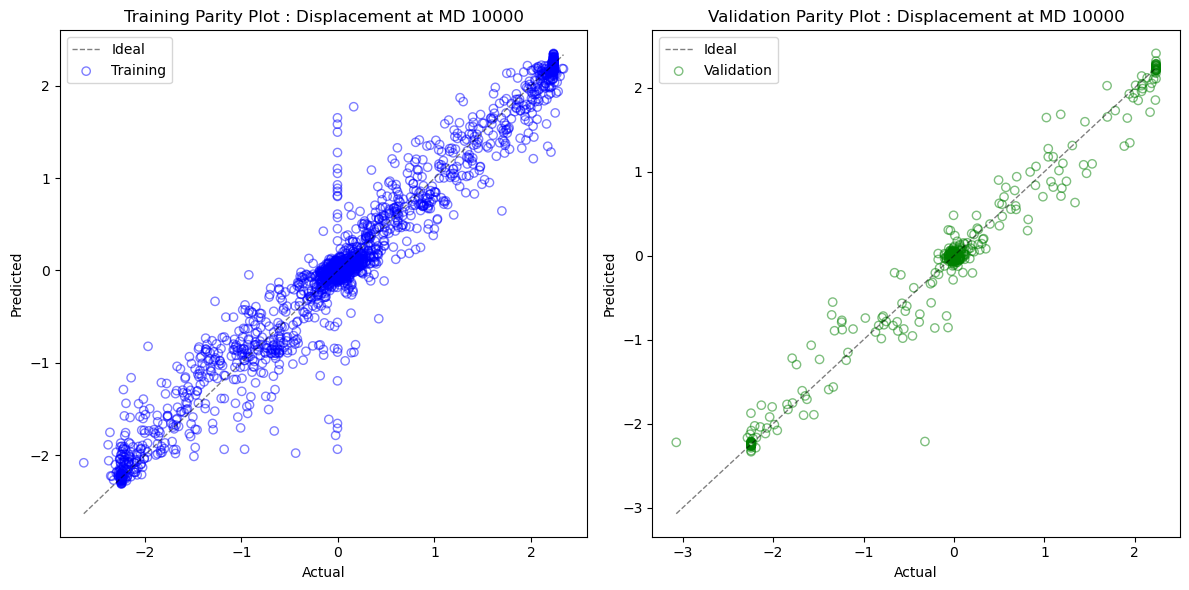

In [312]:
parity_plot(actual_train, predicted_train, actual_val, predicted_val, " ".join([": Displacement at MD", time]))

The parity plots look good! However, you may notice that the RMSE did not improve (probably) over this epoch after picking up training from the saved state. This will be discussed below.

For now, feel free to play around with the code and run more epochs. Maybe you'll see the RMSE improve!

### Results

In the above parity plots, the actual and predicted values are plotted as transparent circles. This allows us to clearly see where the bulk of the data is located. Since at 10 000 timesteps, particles have not undergone much displacement with the exception of wall particles, we see large clusters of data around $\pm 2$ standard deviations from $\mu = 0$ corresponding to the wall particles as well as a large cluster of particles which have undergone little to no displacement. At MD 50 000 timesteps, the cluster around $0$ is less concentrated since the information from the moving walls has had some time to travel toward the middle of the system.

In both parity plots, you might notice a vertical line, which denotes a presence of false positives. In other words, the model is predicting displacements for particles which in reality undergo little to no displacement. I'm referring to this as the "false positive 'scare'" detailed below. 

#### The false positive 'scare'

Initially, we did not plot the actual and predicted values with clear circles and could not discern the data density of different displacement values as easily. As a result, we were quite concerned about the presence of the false positive line. Nonetheless, this led to a fruitful discussion of the physics at play and the creation of some nice plots.

To better identify the source of these false positives, we wanted to understand the location of the particles that were being identified as false positives. So, we plot the actual and predicted values as a function of the epoch for certain regions of the simulation box:

![displacement predictions as a function of epoch for the 500 epoch run on MD 10 000 data](./images/displacment_predictions_MD10000_bottomwall.png)

Here, we're zeroing in on the particles with y-coordinates between the 5 and 7.25 percentiles at the bottom of the gridbox. The walls are defined to contain all the particles within six big particle radii of the bottom of the simulation:

$ y_{wall} = 6 * 1.4 = 8.4 $

$ L_{y} = 166.91 $

$ \mathrm{wall\_percentile} = 8.4 / 166.91 = 0.0503265 \approx 5 \%$

So selecting particles with y-coordinates in the first 2.25 percentiles above 5 percent means that we're looking at the particles closest to the bottom walls.

The light blue lines represent the predictions generated by the model for each particle, while the light dotted red lines represent the actual displacement values of each particle (constant across all epochs). If our model managed to predict the displacements of every single particle perfectly, then we would see each little blue line converge to a little dotted red line over the course of the training. However, that's not important to a GNN. We are minimizing the root *mean* squared error, and that's why you see the thick blue line (prediction mean) follow the thick dotted red line (target mean). On average, we are predicting the displacements of the particles very well. And, on average, the particles are moving leftward, at a rate of about $-2.2$ standard deviations from the mean across the whole simulation box ($0$). 

You'll notice a few dotted red lines around 0, or at standardized displacement values much less than the thick red line (target mean of particles close to bottom wall). These particles are somewhat anomalous, so the model does not care too much about them. That's why you don't see thin blue lines tracking the anomalously low displacement particles' red dotted lines in the figure above. This is what causes the false positive line on our training parity plots. Below, in the heatmap of x-displacements at 50 000 timesteps, you'll see that the presence of these anomalously low-displacement particles near the walls is warranted. There are white spots on the heatmap near the walls corresponding to particles which have not moved much at all!

So, although the model does get these particles "wrong," it's not so concerning since there are so few of them. Indeed, there are so few of them that they barely show up in the validation parity plot (which constitutes only 10% of the particles).

In the end, we've only increased our confidence in the model's predictive power as a result of the false positive 'scare,' yet we've learned valuable things about the system's characteristics and gained equally valuable analysis tools.

![X displacement heatmap, MD50000](./images/displacement_plots/plots/disp_MD_50000_X.png)

## Future work

Although this semester has allowed us to explore GNNs and their applications to soft matter systems in some detail, there is still much to be learned about GNNs, much more to tinker with, and many more tasks to ask of the GNN.

First, although we understand RMSE is a standard choice for a loss function which is well suited for regression tasks, we'd like to understand the nuances of other loss functions available [here](https://docs.pytorch.org/docs/stable/nn.html#loss-functions). Additionallyt, although my choice of initial learning rate, learning rate schedulers, and their hyperparameters was informed by some research and testing, I feel that a much deeper exploration of the possible scheduler combinations and hyperparameters is necessary. In the figure above comparing different scheduler configurations, the best and the worst performing configurations corresponded to the same schedulers (exponential, multi-step, and reduce on plateau) but with different hyperparameters. This indicates that there is perhaps much more room to improve or that perhaps another choice of schedulers and hyperparameters could produce a more robust model.

Another choice in the model which I am curious to explore further is the [optimizer](https://docs.pytorch.org/docs/stable/optim.html#algorithms). We use Adam, but alternatives like AdamW or Lion could be worth trying. 

Personally, I'd also like to better understand certain design choices in the GNN architecture, from, for example, the $\texttt{MP\_Layers}$ parameter to other options for [nonlinear activation functions](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) (like LeakyReLu). I also wonder if the added complexity of something like a [dropout layer](https://docs.pytorch.org/docs/stable/nn.html#dropout-layers) could allow the GNN to further generalize its predictive power to disparate contexts.

Next, the way in which I implement standardization in the code feels somewhat dirty. As such, I would like to explore cleaner alternatives. Would [BatchNorm1d](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d) layers be an improvement over my current implementation in any way?

In the same vein, I wonder if the tracking of loss over time might be done in a cleaner way. Would
    
    from torchmetrics import MeanMetric

be worth looking into?

In general, I feel we've only scratched the surface of tuning, optimization, and training of the model for displacement at 10000 and 50000 MD time steps. I have also attempted to study displacement over 100000 MD steps using a nonzero initial MD step—in fact, the initial step was quite far along in the simulation. However, we encountered some bugs and were unsure if the data was processing correctly given the system behaves quite differently at long times, and we did not have enough time to adequately answer our questions before the semester's end.

One concrete improvement to the GNN code I can easily make is to the method of picking up training from a bestmodel.pkl or savedmodel.pkl file. Currently, running

    torch.save(model, "savedmodel.pkl")

only saves the model architecture and weights. We write the learning rates and epochs to a file, and so we can hard-code a pick-up from the last learning rate by reading this file. However, we have no way of recovering the optimizer state. This means the path which we had been charting to a nice minimum in the loss function is lost to the ages when we resume training from a .pkl file. The below code, once added to the GNN script, will allow for a much cleaner pick-up which might translate to an immediate improvement in the RMSE after a pick-up from a converging model.

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr': optimizer.param_groups[0]['lr'],
        'epoch': epoch
    }, 'savedmodel.pkl')
    checkpoint = torch.load('savedmodel.pkl')
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr = checkpoint.get('lr', optimizer.param_groups[0]['lr'])


Finally, we often see in the literature that there is a lot of discussion of the generalizability of a model to portions of a sample space which have not been explored in training. However, I remain unsure as to how exactly to test a trained model on what is somewhat of a different task. In other words, I'd like to explore the mechanisms and theory behind this principle.

More specifically, for our task, the most immediate extension of the model's predictive domain is to predict displacement for longer times using a model trained on shorter times. We could start from something as simple as moving from 10000 time steps to 20000, then from 20000 to 50000, and beyond.

Furthermore, we can introduce new variations to the task and to the system: Pins would introduce non-affine dynamics to the system, so would the model be able to adjust to this? With training on pin data? And without? And if the model can predict displacements in a system with pins, can it also predict non-affine displacements with some slight modification to the pre-processor?

In a brief comparison to [Mandal & Sollich (2022)](https://doi.org/10.1038/s41467-022-31732-3), perhaps it could be interesting to fine-tune the $\texttt{edge\_threshold}$ parameter which governs the relative distance between particles below which we draw an edge between them in the graph representation of the system. Mandal and Sollich use a threshold of $2 R_{B} = 2.8$, and we have used $3.0$ and $5.0$. We have seen (c.f. Siddhant's report) that this parameter is extremely powerful in tasks that predict distances (i.e. distance to nearest pin) since the region in which the model can with certainty draw connections between nodes is equal to the number of message passing layers times the edge threshold parameter. So, how would this change the model's performance in other tasks like x-displacement?

Mandal and Sollich also train the model for over a thousand epochs whereas we stuck with 500. Without the rush of the semester, perhaps we can try more epochs for a few training runs after having fine-tuned the model architecture and parameters. Would our results improve if we train for a very large number of epochs?

Clearly, there is much more to be done with the GNN!